In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima
from scripts.python.tsa.utsmodel import *
from scripts.python.tsa.ts_utils import *
from scripts.python.tsa.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

## Load, Merge

,date,total,stringency_index,covid,solomon_islands_flights,solomon_islands_hotel,solomon_islands_travel
0,2009-01-01,1602,0.0,0.0,0.000000,0.0,0.000000
1,2009-02-01,1422,0.0,0.0,0.484667,0.0,0.203672
2,2009-03-01,1249,0.0,0.0,0.000000,0.0,0.000000
3,2009-04-01,1499,0.0,0.0,0.000000,0.0,0.000000
4,2009-05-01,1393,0.0,0.0,0.000000,0.0,0.478020


Training samples do not cover covid-19 periods. Instead, Run All Samples.
training size : 144, testing size : 0
THE BENCHMARK EVALUATION FOR SOLOMON_ISLANDS 

STARTED TO CONDUCT STEPWISE SEARCHING FOR SOLOMON_ISLANDS 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -170.543
Date:                              Mon, 22 May 2023   AIC                            361.087
Time:                                      14:45:11   BIC                            390.715
Sample:                                           0   HQIC                           373.126
                                              - 144                                         
Covariance Type:                                opg                                         
                             coef    

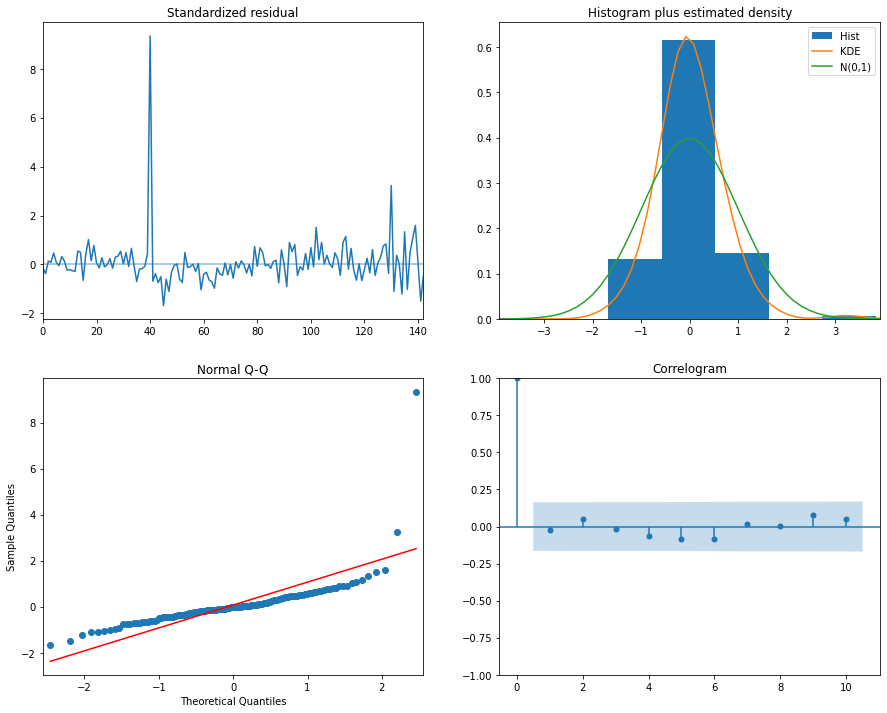

STARTED TO CONDUCT GRID SEARCHING FOR SOLOMON_ISLANDS 

STARTED TO CONDUCT CROSS-VALIDATION FOR SOLOMON_ISLANDS 

Best Models from Cross-validation is  ARIMA(1,1,1)(0,1,1)[12] intercept 



,MSE,RMSE,MAE,SMAPE
naive,130146.048951,360.757604,273.083916,19.605133
mean,373388.932822,611.055589,428.780575,28.510498
seasonal naive,719201.125000,848.057265,537.375000,42.210038
SARIMAX,87084.324016,295.100532,213.142277,15.277422


In [4]:
countries = ["solomon_islands"]
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

for country in countries:

    mod = SARIMAXPipeline(country=country, y_var="total",
                          data=None,
                          exog_var=["covid", "stringency_index",
                                    str(country)+"_travel"],
                          transform_method="scaledlogit",
                          training_ratio=0.9,
                          verbose=False)
    mod.read_and_merge()
    display(mod.data.head(5))
    
    
    mod.transform()
    print(f"The Benchmark Evaluation for {country}".upper(), "\n")
    mod.get_benchmark_evaluation()
    print(f"Started to conduct stepwise searching for {country}".upper(), "\n")
    mod.stepwise_search()

    print(f"Started to conduct Grid searching for {country}".upper(), "\n")
    mod_msres = mod.manual_search(params=all_param)
    mod_msres.sort(key=lambda x: x[1])

    mod_swm = mod.stepwise_model
    if mod_msres[0][-1] == (mod_swm["order"], mod_swm["seasonal_order"]):
        print(mod_msres[0][-1])
    else:
        cv_models = []
        cv_models.append(pm.ARIMA(
            mod_swm["order"], mod_swm["seasonal_order"],  exog=mod.exog[:mod.training_size]))

        # Append top five GridSearch results
        for res in mod_msres[:5]:
            order, seasonal_order = res[-1]
            model = pm.ARIMA(order, seasonal_order,
                             exog=mod.exog[:mod.training_size])
            cv_models.append(model)

        print(
            f"Started to conduct Cross-validation for {country}".upper(), "\n")
        mod_cv_comp = mod.compare_models(
            y=mod.transformed_y, exog=mod.exog, models=cv_models)
        best_cv_idx = np.argmin(mod_cv_comp["avg_error"])
        print(
            f"Best Models from Cross-validation is {cv_models[best_cv_idx]}", "\n")

        if best_cv_idx > 0:
            best_mod = mod_msres[best_cv_idx-1][0]
            best_mod_pred = mod.get_prediction_df(
                best_mod, mod.test_size, mod.exog[-mod.test_size:])
        
        lower = mod.data["total"].min() - 1
        upper = mod.data["total"].max() + 1
        for col_idx, col in enumerate(best_mod_pred.columns):
            for row_idx, _ in enumerate(best_mod_pred[col]):
                best_mod_pred.iloc[row_idx, col_idx] = mod.inverse_scaledlogit(
                    best_mod_pred.iloc[row_idx, col_idx], upper, lower)

        # Merge the prediction with actual values
        best_mod_pred.columns.name = None
        best_mod_pred = pd.concat(
            [mod.data[["date", "total"]], best_mod_pred], axis=1)

        if mod.test_size != 0:
            pred_series = (best_mod_pred["train_pred"].fillna(0)
                           + best_mod_pred["test_pred"].fillna(0))
        else:
            pred_series = best_mod_pred["train_pred"]
        
        mod_eval = (pd.DataFrame(calculate_evaluation(
            best_mod_pred["total"], pred_series), index=["SARIMAX"]))
        mod_eval = pd.concat([mod.benchmark, mod_eval], axis=0)
        display(mod_eval)

Text(0.5, 1.0, "Solomon Islands' Visitor Arrivals")

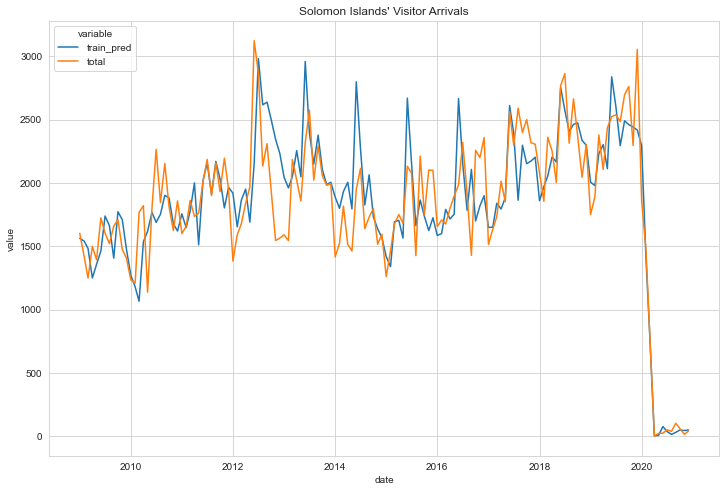

In [8]:
viz_df = best_mod_pred[["date", "train_pred", "total"]].melt(id_vars=["date"])
viz_df["date"] = pd.to_datetime(viz_df["date"])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
plt.title("Solomon Islands' Visitor Arrivals")

## Ratio Approach

In [12]:
from scripts.python.tsa.mtsmodel import *


SOLOMON_ISLANDS's Official and Avaition Data.

 Create Loaded Factor for SOLOMON_ISLANDS:

 Regression SOLOMON_ISLANDS:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.939
Model:                            WLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     35.46
Date:                Mon, 22 May 2023   Prob (F-statistic):           1.40e-08
Time:                        14:52:50   Log-Likelihood:                 54.264
No. Observations:                  24   AIC:                            -92.53
Df Residuals:                      16   BIC:                            -83.10
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.174372,1750,10036.0,0.212880,0.017319,0.176165,0.249595,0.137798,0.287962,2136.464988
1,2019-02-01,0.199662,1891,9471.0,0.208311,0.015656,0.175121,0.241501,0.134889,0.281734,1972.917412
2,2019-03-01,0.245332,2378,9693.0,0.201838,0.019636,0.160211,0.243464,0.124236,0.279439,1956.411325
3,2019-04-01,0.220940,2106,9532.0,0.242741,0.016423,0.207926,0.277556,0.168570,0.316912,2313.809745
4,2019-05-01,0.246881,2434,9859.0,0.252211,0.019415,0.211054,0.293368,0.174860,0.329562,2486.545575


,MSE,RMSE,MAE,SMAPE
mean,1.290167e+06,1135.855000,1065.215278,100.969388
naive,1.721267e+05,414.881597,268.478261,46.835106
ratio,4.875343e+04,220.801780,150.232442,26.614403


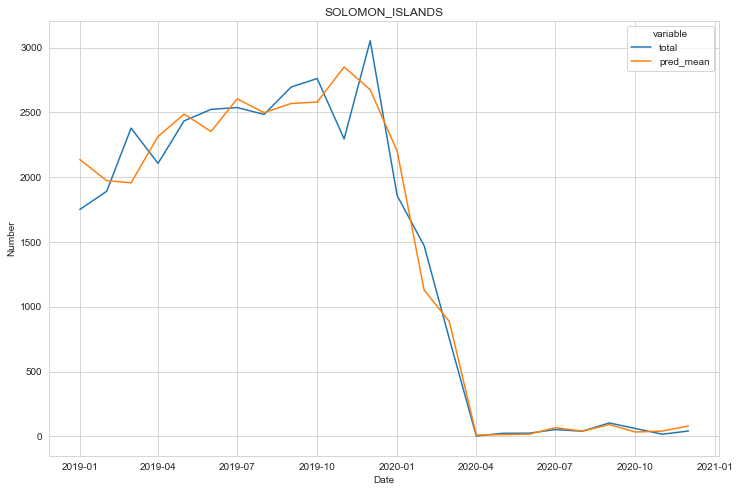

In [13]:
country = "solomon_islands"
mod = RatioPipe(country=country, data=None)
print(f"\n{country.upper()}'s Official and Avaition Data.")
mod.read_and_merge()

print(f"\n Create Loaded Factor for {country.upper()}:")
mod.transform()

print(f"\n Regression {country.upper()}:")
mod.fit()
pred_df = mod.get_prediction_df()

mean_pred, naive_pred = \
    mean_method(pred_df["total"]), naive_method(pred_df["total"])

benchmark = pd.DataFrame()
eval_name = ["mean", "naive", "ratio"]
for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
    eval_df = pd.DataFrame(calculate_evaluation(
        pred_df["total"], pred), index=[idx])
    benchmark = pd.concat([benchmark, eval_df])
display(benchmark)

ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
plt.show()

### Future Forecasting

In [131]:
gt = mod.read_trends_data()
gt.columns = [col.replace(" ", "_") for col in gt.columns]
solomon_si = mod.read_covid_data()

In [132]:
solomon_si_fu = (solomon_si[solomon_si.date >="2021-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (solomon_si_fu.merge(
    gt[["date", "solomon_islands_flights", "solomon_islands_travel"]],
    how="left", on="date"))
temp_fu["covid"] = (temp_fu.date >= "2020-03-12").astype(int)
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu = temp_fu.dropna() 

In [134]:
uni_future = (best_mod.get_forecast(
    exog=temp_fu[["covid", "stringency_index", "solomon_islands_travel"]],
    steps=len(temp_fu))
    .summary_frame())
uni_future.columns.name = None
for col_idx, col in enumerate(uni_future.columns):
    for row_idx, _ in enumerate(uni_future[col]):
        uni_future.iloc[row_idx, col_idx] = inverse_scaledlogit(
            uni_future.iloc[row_idx, col_idx], upper, lower)

uni_future = (uni_future.reset_index()
              .drop("index", axis=1))
uni_future.columns = [col.replace("mean", "uni") for col in uni_future.columns]
uni_future["date"] = temp_fu["date"]
uni_future.head(5)

,uni,uni_se,uni_ci_lower,uni_ci_upper,date
0,26.757696,2150.158365,6.483658,119.146777,2021-01-01
1,30.595898,2168.907952,6.969071,143.466833,2021-02-01
2,44.537588,2174.534672,9.667315,210.267847,2021-03-01
3,35.954154,2178.733213,7.857143,172.827838,2021-04-01
4,47.255529,2182.688047,9.994683,227.633617,2021-05-01


In [135]:
future = mod.res.get_prediction(temp_fu).summary_frame()
future["date"] = temp_fu["date"]

In [136]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

sb_avi = (aviation[(aviation.ISO == "SB") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
sb_avi["Date"] = pd.to_datetime(sb_avi["Date"])
sb_avi["Month"], sb_avi["Year"] = sb_avi["Date"].dt.month, sb_avi["Date"].dt.year
sb_avi = sb_avi.groupby(["Year", "Month"]).sum().reset_index()
sb_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(sb_avi.Year, sb_avi.Month)]
sb_avi["date"] = pd.to_datetime(sb_avi["date"])
sb_avi_future = sb_avi[sb_avi.date >= "2021-01-01"].reset_index().drop("index", axis=1)
sb_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2021,1,1408,1408,2021-01-01
1,2021,2,1640,1640,2021-02-01
2,2021,3,1632,1632,2021-03-01
3,2021,4,2164,2164,2021-04-01
4,2021,5,1292,1444,2021-05-01


In [137]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "lf")
        future[colname] = sb_avi_future["Seats_arrivals_intl"] * future[col]
future.head(5)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,lf,lf_ci_lower,lf_ci_upper
0,-0.013964,0.026056,-0.069200,0.041273,-0.099639,0.071712,2021-01-01,-19.660781,-97.433629,58.112068
1,-0.021852,0.032473,-0.090691,0.046987,-0.116869,0.073164,2021-02-01,-35.837449,-148.733861,77.058963
2,-0.017247,0.028630,-0.077941,0.043447,-0.106539,0.072045,2021-03-01,-28.147308,-127.199789,70.905173
3,0.032983,0.025983,-0.022098,0.088064,-0.052592,0.118559,2021-04-01,71.375570,-47.819590,190.570729
4,0.026719,0.025154,-0.026605,0.080043,-0.057737,0.111174,2021-05-01,34.520820,-34.373918,103.415558


In [145]:
forecast = future.iloc[:, -4:]
forecast = forecast.merge(uni_future)
forecast.to_csv(os.getcwd() + "/data/tourism/solomon_islands/model/future.csv", encoding="utf-8")

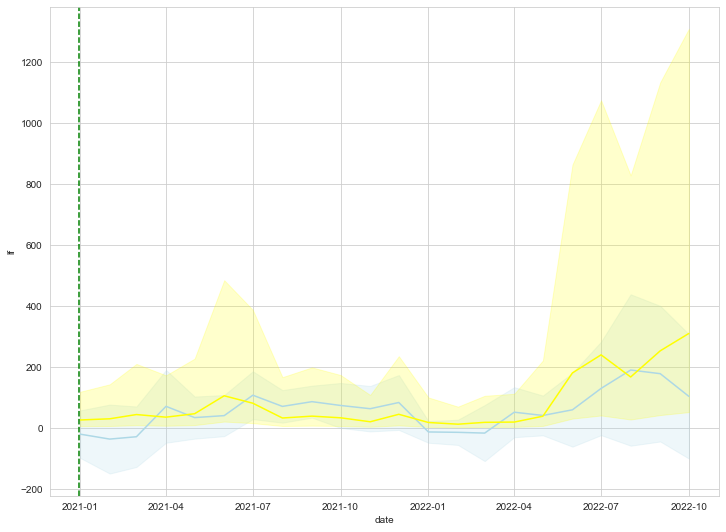

In [144]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=forecast, x="date", y="lf", color="lightblue")
sns.lineplot(data=forecast, x="date", y="uni",  color="yellow")
ax.fill_between(data=forecast, x="date", y1="lf_ci_lower",
                y2="lf_ci_upper", alpha=0.2, color="lightblue")
ax.fill_between(data=forecast, x="date", y1="uni_ci_lower",
                y2="uni_ci_upper", alpha=0.2, color="yellow")
plt.axvline(datetime(2020, 12, 31), linestyle="--", color="green")
plt.show()